In [3]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, Word2Vec, StringIndexer, IndexToString, Tokenizer 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier 
from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.sql.types import IntegerType, StringType 
from pyspark.sql import functions as F 
import matplotlib.pyplot as plt 
import pandas as pd 
from wordcloud import WordCloud

#import wordcloud as WordCloud

In [4]:
def displayPartitions(df):
    #get the number of records by partition
    num = df.rdd.getNumPartitions()
    print("Total number of Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)


In [5]:
spark = SparkSession.builder.appName('Trump-Tweet-Analysis').getOrCreate()

In [6]:
#df = spark.read.json("gs://dataproc-staging-us-central1-575311154882-olmcvswv/notebooks/jupyter/")
df = spark.read.json("gs://bigdatafinaldatakira/trump_tweets.json")
print(f"Reading {df.count()} tweets in total.")

Reading 56571 tweets in total.


In [7]:
trump_texts = df.select("text")
trump_texts.show(5)

+--------------------+
|                text|
+--------------------+
|Republicans and D...|
|I was thrilled to...|
|RT @CBS_Herridge:...|
|The Unsolicited M...|
|RT @MZHemingway: ...|
+--------------------+
only showing top 5 rows



In [9]:
trump_texts = trump_texts.na.drop(subset=["text"])

# delete @mentions
trump_texts = trump_texts.withColumn('text', F.regexp_replace(F.col('text'), '@\S+', ''))

# delete RTs
trump_texts = trump_texts.withColumn('text', F.regexp_replace(F.col('text'), 'RT', ''))

# delete amp
trump_texts = trump_texts.withColumn('text', F.regexp_replace(F.col('text'), 'amp', ''))

# tolower
trump_texts = trump_texts.withColumn("text", F.lower(F.col("text")))



# Keep only alpha & num
trump_texts = trump_texts.withColumn("text", F.regexp_replace(F.col("text"), "[^a-zA-Z0-9\s]", ""))

# Remove unnecessary spaces
trump_texts = trump_texts.withColumn("text", F.trim(F.col("text")))

# Remove empty text
trump_texts = trump_texts.filter(F.length(F.trim(trump_texts.text)) > 0)

# Show
trump_texts.show(5)

+--------------------+
|                text|
+--------------------+
|republicans and d...|
|i was thrilled to...|
|read letter to su...|
|the unsolicited m...|
|very friendly tel...|
+--------------------+
only showing top 5 rows



In [10]:
# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")

# Stop words removal
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

In [11]:
word_cloud_pipeline = Pipeline(stages=[tokenizer, remover])
trump_texts = word_cloud_pipeline.fit(trump_texts).transform(trump_texts)
trump_texts = trump_texts.select("filtered")
trump_texts.show(5)

+--------------------+
|            filtered|
+--------------------+
|[republicans, dem...|
|[thrilled, back, ...|
|[read, letter, su...|
|[unsolicited, mai...|
|[friendly, tellin...|
+--------------------+
only showing top 5 rows



In [12]:
# convert to pandas DataFrame for word cloud generation
pandas_df = trump_texts.toPandas()
pandas_df.head()

,filtered
0,"[republicans, democrats, created, economic, pr..."
1,"[thrilled, back, great, city, charlotte, north..."
2,"[read, letter, surveillance, court, obtained, ..."
3,"[unsolicited, mail, ballot, scam, major, threa..."
4,"[friendly, telling, events, comeys, apparent, ..."


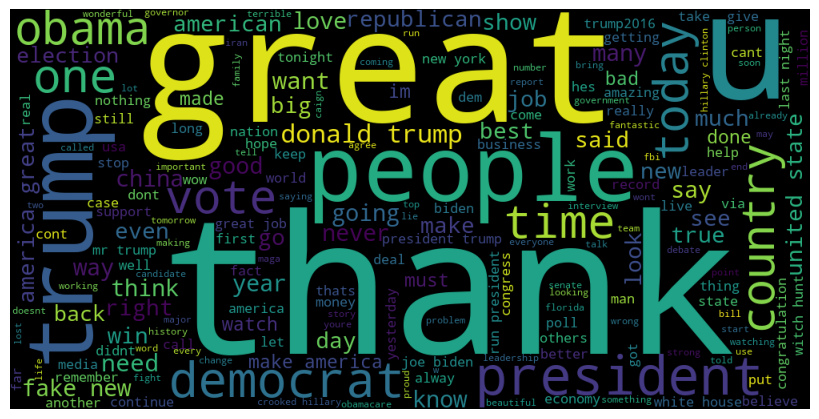

In [13]:
# join the list of words into a single string
text = ' '.join([' '.join(row.filtered) for index, row in pandas_df.iterrows()])

# generate word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(text)

# plot the WordCloud image   
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 